<a href="https://colab.research.google.com/github/JapeTheEternalChild/LSTM-Streamflowprediction-with-Keras/blob/main/LSTM_keras_Rainfall_Runoff_Experiment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rainfall-runoff modelling using Long Short-Term Memory (LSTM) networks (Library:Keras)
##Experiment 1


## Load libraries

In [ ]:
# import libraries
from pydrive.drive import GoogleDrive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
import glob
# load keras and co
import keras
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import CuDNNLSTM
from keras import backend as K
import torch
# from sklearn
from sklearn.preprocessing import MinMaxScaler

## mount google drive & GPU connect

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Define functions

In [ ]:
# Import & Preprocess Data Function

def read_data(filename_daymet, filename_flow):
  # daily metereo mean data
  daymet = pd.read_csv(filename_daymet, sep='\t', header=4)
  daymet.columns =['Datetime', 'dayl(s)', 'prcp(mm/d)', 'srad(W/m2)', 'swe(mm)', 'tmax(c)', 'tmin(C)', 'vp(Pa)']  # name columns
  # get catchment area
  with open(filename_daymet, 'r') as fp:
      content = fp.readlines()
      area = int(content[2])
  # daily streamflow data
  flow = pd.read_csv(filename_flow, header=None, delim_whitespace=True)
  flow = flow[4] # select column
  flow = flow[1:] # drop first line 1.1.1980 because daymet starts from the 2.1.1980
  flow.reset_index(drop=True, inplace=True) # reset index
  flow = 28316846.592 * flow * 86400 / (area * 10 ** 6) # from cubic feet per second to equivalent water column in mm
  # combine daymet and streamflow
  data = pd.concat([daymet, flow], axis=1)
  data['Datetime'] =  pd.to_datetime(data['Datetime'], format='%Y %m %d %H')  # set Datetime format
  data['Datetime'] = pd.to_datetime(data['Datetime']).dt.date # drop hours
  data = data.set_index(pd.DatetimeIndex(data['Datetime']))
  data = data.drop(['swe(mm)'], axis=1)
  data = data.drop(['Datetime'], axis=1)
  data = data.drop(['dayl(s)'], axis=1)
  data_old = data.shape[0]
  # delete missing data
  
  data.columns =['prcp(mm/d)', 'srad(W/m2)', 'tmax(c)', 'tmin(C)', 'vp(Pa)', 'Q_spec(mm)']  # name columns
  idxNegatives = data[data['Q_spec(mm)'] < 0].index 
  data.drop(idxNegatives, inplace = True)
  data.dropna(inplace = True)
  # Print how many samples where deleted
  deleted = data_old-data.shape[0]
  print( deleted, 'SAMPLES WHERE DELETED DUE TO MISSING DATA')

  return data

# split data

def split_data1(data):
  df_train = data['1980-10-01':'1995-09-30']
  df_test = data['1995-10-01':'2010-09-30']
  return df_train, df_test

# Z-Standartization --> scaling of data (mean=0, standard deviation = 1)

def local_standartization(data):
  stds = data.std()
  mean = data.mean()
  scaled_data = (data-mean)/stds
  return scaled_data, stds, mean

def scale(data, stds, mean):
  scaled_data = (data-mean)/stds
  return scaled_data

# Rescaling discharge values 

def rescale(data_discharge, stds, mean):
  y_stds = stds.loc['Q_spec(mm)']
  y_mean = mean.loc['Q_spec(mm)']
  rescaled_discharge = (data_discharge * y_stds) +  y_mean
  return rescaled_discharge

# shift timeseries for t days

def shift(data, t):
  data_to_shift = data.drop(['Q_spec(mm)'], axis = 1)
  Q = data['Q_spec(mm)']
  lags= range(0,t)
  data_shifted = pd.concat([data_to_shift.shift(t).add_suffix(f" (t-{t})") for t in lags], axis=1)
  data_shifted = pd.concat([data_shifted, Q], axis = 1)
  return data_shifted

# split dataframe into train and test data; define input(x) and control(y) values; reshape input df from 2D to 3D

def split_data(train_shifted, test_shifted):
  #df_train = train_shifted['1980-10-01':'1995-09-30']
  #df_test = test_shifted['1995-10-01':'2010-09-30']
  y_train = train_shifted['Q_spec(mm)'].values
  x_train = train_shifted.loc[:, train_shifted.columns != 'Q_spec(mm)'].values
  y_test = test_shifted['Q_spec(mm)'].values
  x_test = test_shifted.loc[:, test_shifted.columns != 'Q_spec(mm)'].values
  #x_train = np.expand_dims(x_train,2)
  #x_test = np.expand_dims(x_test, 2)
  return y_train, x_train, y_test, x_test

#NSE function
def get_nse(y_test, predictions):
  numerator = sum([(y_test[i]-predictions[i])**2 for i in range(len(y_test))])
  y_test_avg = sum(y_test)/len(y_test)
  denominator = sum([(y_test[i]-y_test_avg)**2 for i in range(len(y_test))])
  NSE = 1- (numerator/denominator)
  return NSE

def calc_nse(obs: np.array, sim: np.array) -> float:
    """Calculate Nash-Sutcliff-Efficiency.

    :param obs: Array containing the observations
    :param sim: Array containing the simulations
    :return: NSE value.
    """
    # only consider time steps, where observations are available
    sim = np.delete(sim, np.argwhere(obs < 0), axis=0)
    obs = np.delete(obs, np.argwhere(obs < 0), axis=0)

    # check for NaNs in observations
    sim = np.delete(sim, np.argwhere(np.isnan(obs)), axis=0)
    obs = np.delete(obs, np.argwhere(np.isnan(obs)), axis=0)

    denominator = np.sum((obs - np.mean(obs)) ** 2)
    numerator = np.sum((sim - obs) ** 2)
    nse_val = 1 - numerator / denominator

    return nse_val

#using NSE as metrics function
def metrics_nse(y_obs,y_sim):
  numerator = K.sum(K.square(y_sim - y_obs))
  denominator = K.sum(K.square(y_obs - K.mean(y_obs)))
  return 1-(numerator/denominator)

#using NSE as loss function
def loss_NSE(y_obs, y_sim):
  numerator = K.sum(K.square(y_sim - y_obs))
  denominator = K.sum(K.square(y_obs - K.mean(y_obs)))
  return numerator/denominator

#LSTM

def model_lstm(x_train, loss, metrics):
  model = Sequential()
  model.add(LSTM(20, input_shape=x_train.shape[1:], return_sequences = True, activation = "tanh"))
  model.add(Dropout(0.1))
  model.add(LSTM(20, activation = "tanh"))
  model.add(Dropout(0.1))
  model.add(Dense(1))
  model.compile(loss=loss, optimizer='adam', metrics=metrics)

  print(model.summary())

  return model

# optimizer



# GRU
''' gated recurrent unit after Cho, et al. in 2014
using a keras based sequencial model '''

def model_gru(x_train, loss, metrics):
  model = Sequential()
  model.add(GRU(20, activation="tanh", input_shape=x_train.shape[1:], use_bias=True, return_sequences = True, recurrent_activation="sigmoid"))
  model.add(Dropout(0.1))
  model.add(GRU(20, activation="tanh", use_bias=True, recurrent_activation="sigmoid"))
  model.add(Dropout(0.1))
  model.add(Dense(1))
  model.compile(loss=loss, optimizer=opt, metrics=metrics)

  print(model.summary())

  return model

# Train the Model

def train(model, x_train, y_train, epochs, batch_size):
 history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=False)
 return history

 # Evaluate model

def get_accuracy(model,x,y):
 loss = model.evaluate(x, y)
 return loss

# Validation

def prediction(model, x_test):
  predictions = model.predict(x_test)
  return predictions

def lstm_data_transform(x_data, y_data, num_steps=5):
    """ Changes data to the format for LSTM training 
for sliding window approach """
# Prepare the list for the transformed data
    X, y = list(), list()
# Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
# if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
# Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix]
# Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
# Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    return x_array, y_array


# Callbacks

class CustomCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    y_pred = self.model.predict(self.validation_data[0])



## Test

If validation loss >> training loss you can call it overfitting.

If validation loss  > training loss you can call it some overfitting.

If validation loss  < training loss you can call it some underfitting.

If validation loss << training loss you can call it underfitting.

In [ ]:
#make prediction
predictions= prediction(model, x_test_transformed)
training_pred = prediction(model, x_train_transformed)

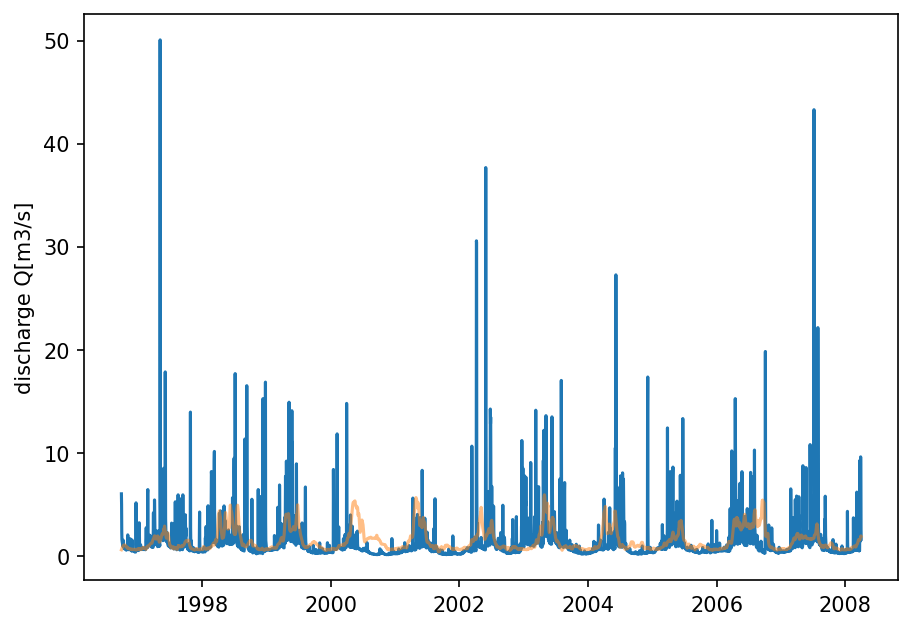

In [ ]:
#print predicitons 
pred_rescaled = rescale(predictions, test_mean, test_std)
df_test_new = data['1996-09-30':'2010-09-30']
# plot example
fig=plt.figure(figsize=(7, 5), dpi= 150, facecolor='w', edgecolor='k')
plt.plot(df_test_new.index, df_test_new['Q_spec(mm)'])
plt.ylabel('discharge Q[m3/s]')
plt.plot(df_test_new.index, pred_rescaled.flatten(), alpha=0.5)
plt.show()

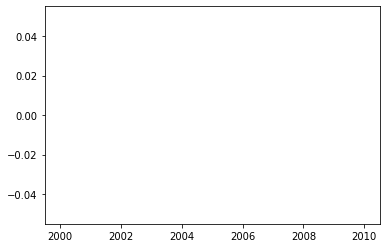

In [ ]:
#plt.plot(pred_rescaled)
plt.plot(df_test_new['Q_spec(mm)'])


In [ ]:


nse_val = get_nse(data['Q_spec(mm)']['1996-09-30':'2010-09-29'].values, pd.Series(pred_rescaled.flatten).values)

print(nse_val)

TypeError: ignored

In [ ]:
lala = pd.Series(pred_rescaled.flatten(), index=df_test_new['Q_spec(mm)'].index)

In [ ]:

nse_val = get_nse(df_test_new['Q_spec(mm)']['1997-09-30':'2010-09-30'], lala['1997-09-1':'2010-09-29'])

print(nse_val)

-0.34880611295422925


In [ ]:
def nse(obs, sim):
  obs_mean = np.mean(obs)
  nse = 1-np.mean((obs - sim)**2)/(np.mean((obs - obs_mean)**2))
  return(nse)

In [ ]:
obs = df_test_new['Q_spec(mm)']['1996-09-30':'2010-09-29']
sim = lala['1996-10-01':'2010-09-30']

In [ ]:
nse(obs.values, sim.values)

-1763.0272497955402

In [ ]:
df_test_new['Q_spec(mm)']['1997-09-30':'2010-09-30']

Datetime
1997-09-30    0.134748
1997-10-01    0.132951
1997-10-02    0.125765
1997-10-03    0.123968
1997-10-04    0.122171
                ...   
2010-09-26    0.122171
2010-09-27    0.118578
2010-09-28    0.116782
2010-09-29    0.116782
2010-09-30    0.116782
Name: Q_spec(mm), Length: 4749, dtype: float64

## TEST new

In [ ]:
huc = '03'
basin_ID = '02395120'
filename_daymet ='/content/drive/My Drive/Colab Notebooks/basin_mean_forcing/daymet/'+huc+'/'+basin_ID+'_lump_cida_forcing_leap.txt'
filename_flow   ='/content/drive/My Drive/Colab Notebooks/usgs_streamflow/'+huc+'/'+basin_ID+'_streamflow_qc.txt'
data = read_data(filename_daymet, filename_flow)

df_train, df_test = split_data1(data)
scaled_train, train_std, train_mean = local_standartization(df_train)
scaled_test = scale(df_test, train_std, train_mean)
y_train_sc, x_train_sc, y_test_sc, x_test_sc = split_data(scaled_train, scaled_test)

151 SAMPLES WHERE DELETED DUE TO MISSING DATA


In [ ]:
df_train

,prcp(mm/d),srad(W/m2),tmax(c),tmin(C),vp(Pa),Q_spec(mm)
Datetime,,,,,,
1980-10-01,6.79,165.57,20.96,14.29,1622.89,0.314059
1980-10-02,0.00,325.26,24.30,13.64,1571.35,0.314059
1980-10-03,0.00,423.99,23.97,8.00,1080.00,1.199134
1980-10-04,0.00,425.22,20.03,4.34,827.22,0.685220
1980-10-05,0.00,360.05,18.23,6.37,950.15,0.599567
...,...,...,...,...,...,...
1995-09-26,1.00,265.46,21.09,14.34,1627.03,11.563081
1995-09-27,0.00,396.24,23.99,12.32,1425.85,52.533504
1995-09-28,0.00,417.50,25.01,11.91,1392.66,7.508865


In [ ]:
num_steps = 30
# training set
(x_train_transformed,
y_train_transformed) = lstm_data_transform(x_train_sc, y_train_sc, num_steps=num_steps)
assert x_train_transformed.shape[0] == y_train_transformed.shape[0]
# test set
(x_test_transformed,
y_test_transformed) = lstm_data_transform(x_test_sc, y_test_sc, num_steps=num_steps)
assert x_test_transformed.shape[0] == y_test_transformed.shape[0]

In [ ]:
x_test_transformed.shape[0]-df_test.shape[0]

-365

In [ ]:
loss = 'mse'
epochs=500
batch_size = 512


model = model_lstm(x_train_transformed, loss, metrics=metrics_nse)
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.fit(x_train_transformed, y_train_transformed, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 20)            2080      
                                                                 
 dropout_4 (Dropout)         (None, 30, 20)            0         
                                                                 
 lstm_5 (LSTM)               (None, 20)                3280      
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 5,381
Trainable params: 5,381
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
11/11 [============================

In [ ]:
predictions=prediction(model, x_test_transformed)
nse_val = get_nse(y_test_transformed, predictions) 

In [ ]:
nse
#plt.plot( predictions)

-7.141469688013502e+39

In [ ]:
obs = y_test_transformed
sim = predictions

denom = np.sum(obs-np.mean(obs))**2
nom = np.sum(obs-sim)**2
nse = 1- nom/denom
nse

-7.141469688013502e+39

## Routine implementation
LSTM

In [ ]:
RNN='LSTM'

### Specify HUC of interest ###
HUC_ID = '1'
# Define path for daymet
start_path_daymet = '/content/drive/My Drive/Colab Notebooks/basin_mean_forcing/daymet'
final_path_daymet = os.path.join(start_path_daymet, HUC_ID, '*.txt')
#define path for streamflow
start_path_flow = '/content/drive/My Drive/Colab Notebooks/usgs_streamflow'
final_path_flow = os.path.join(start_path_flow, HUC_ID, '*.txt')
# Create List with all filenames (all catchments in HUC)
catchments_daymet = []
catchments_flow = []
for file in glob.glob(final_path_daymet):
    catchments_daymet.append(file)
for file in glob.glob(final_path_flow):
  catchments_flow.append(file)
# Create empty list to store model results in
df_result = []

### METRICS
loss = 'mse'
metrics = metrics_nse
### HYPERPARAMETER ###
t = 365 #lag time(days) input
epochs = 50
batch_size = 512

############# START OF LOOPING THE MODEL FOR ALL CATCHMENTS IN HUC #############
for i in range(len(catchments_daymet)):

  print('--------Loading Data...........................................................')
  # get path
  filename_daymet = catchments_daymet[i]
  # get catchmennt ID
  catchment_ID = os.path.basename(filename_daymet).split('_', 1)[0]
  #get path
  filename_flow = [s for s in catchments_flow if catchment_ID in s]
  # load data
  data = read_data(filename_daymet, filename_flow[0])
  print('--------Data-loading complete--------------------------------------------------')
  print('--------Creating Training and Test samples.....................................')
  # Split Train and Test Data
  df_train, df_test = split_data1(data)
  # Standardize data
  ############ Question how to standardize: [a]=by using statistical values of training set (best when stats of both sets do not differ), [b]=by using training stats for training set and testing stats for test set, [c]=by using complete set stats (worst)
  print('--------Standardizing data.....................................................')
  scaled_train, train_std, train_mean = local_standartization(df_train)
  scaled_test = scale(df_test, train_std, train_mean)
  # split data
  y_train_sc, x_train_sc, y_test_sc, x_test_sc = split_data(scaled_train, scaled_test)
  # create sequences
  print('--------Shaping sequences......................................................')
  num_steps = 365
  # training set
  (x_train_transformed,
  y_train_transformed) = lstm_data_transform(x_train_sc, y_train_sc, num_steps=num_steps)
  assert x_train_transformed.shape[0] == y_train_transformed.shape[0]
  # test set
  (x_test_transformed,
  y_test_transformed) = lstm_data_transform(x_test_sc, y_test_sc, num_steps=num_steps)
  assert x_test_transformed.shape[0] == y_test_transformed.shape[0]
  # initate and compile model, 
  model = model_lstm(x_train_transformed, loss, metrics)
  print('--------START TRAINING OF CATCHMENT '+catchment_ID+' in HUC '+HUC_ID+'--------')
  #print('--------Training period: 1981/10/01 - 1995/09/30------------------------------')
  # train model
  model.fit(x_train_transformed, y_train_transformed, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)
  # accuracy
  #accuracy = get_accuracy(model,x_train_transformed,y_train_transformed)
  print('--------End of Training-------------------------------------------------------')
  print('--------Start of Evaluation---------------------------------------------------')
  #print('--------Evaluation period : '+df_test.ix[0]+'-'+df_test.ix[-1]+'-------------------------------')
  # validation
  predictions= prediction(model, x_test_transformed)
  train_output = prediction(model, x_train_transformed)
  nse_val = get_nse(y_test_transformed, predictions)
  nse_train = get_nse(y_train_transformed, train_output)
  print('Training NSE = ', nse_train)
  print('Validation NSE =', nse_val)
  #print('Validation accuracy (NSE) = ' +nse_val+'-----')
  #store paramters 
  df_result.append([catchment_ID, nse_train, nse_val])
  #print predicitons 
  # create dfs containing model output and observed values (features, and targets)
  pred_rescaled = rescale(predictions, train_std, train_mean)
  train_rescaled = rescale(train_output, train_std, train_mean)
  df_test_short = df_test.iloc[365:,:]
  df_test_short['predictions']= pred_rescaled
  df_train_short = df_train.iloc[365:,:]
  df_train_short['predictions']= train_rescaled
  #df_test = df_test['1996-01-02':'2010-01-01']
  # plot example
  #fig=plt.figure(figsize=(7, 5), dpi= 150, facecolor='w', edgecolor='k')
  #plt.plot(df_test.index, df_test['Q_spec(mm)'])
  #plt.ylabel('discharge Q_spec(mm)')
  #plt.plot(df_test.index, pred_rescaled.flatten(), alpha=0.5)
  #plt.show()
  # save weights
  os.chdir('/content/drive/My Drive/Colab Notebooks/Experiment1/'+RNN+'/loss_MSE/weights')
  model.save_weights(catchment_ID+'_model.h5')
  # save model input and output dataframes
  os.chdir('/content/drive/My Drive/Colab Notebooks/Experiment1/'+RNN+'/loss_MSE/model_predictions')
  df_test_short.to_csv(catchment_ID+'_test_pred.csv')
  df_train_short.to_csv(catchment_ID+'_train_pred.csv')

#initialise dataframe
df_result = pd.DataFrame(df_result, columns=['catchment_ID', 'nse_train', 'nse_val'])
#define current directory
os.chdir('/content/drive/My Drive/Colab Notebooks/Experiment1/'+RNN+'/loss_MSE/results')
#save dataframe with results
df_result.to_csv(HUC_ID+RNN+'_results.csv')
# Show results
print(df_result)


Empty DataFrame
Columns: [catchment_ID, nse_train, nse_val]
Index: []


## Routine implementation
GRU


In [ ]:
### 

RNN = "GRU"

### Specify HUC of interest ###
HUC_ID = '17'
# Define path for daymet
start_path_daymet = '/content/drive/My Drive/Colab Notebooks/basin_mean_forcing/daymet'
final_path_daymet = os.path.join(start_path_daymet, HUC_ID, '*.txt')
#define path for streamflow
start_path_flow = '/content/drive/My Drive/Colab Notebooks/usgs_streamflow'
final_path_flow = os.path.join(start_path_flow, HUC_ID, '*.txt')
# Create List with all filenames (all catchments in HUC)
catchments_daymet = []
catchments_flow = []
for file in glob.glob(final_path_daymet):
    catchments_daymet.append(file)
for file in glob.glob(final_path_flow):
  catchments_flow.append(file)
# Create empty list to store model results in
df_result = []

### METRICS
loss = 'mse'
metrics = metrics_nse
### HYPERPARAMETER ###
t = 365 #lag time(days) input
epochs = 50
batch_size = 512

############# START OF LOOPING THE MODEL FOR ALL CATCHMENTS IN HUC #############
for i in range(len(catchments_daymet)):

  print('--------Loading Data...........................................................')
  # get path
  filename_daymet = catchments_daymet[i]
  # get catchmennt ID
  catchment_ID = os.path.basename(filename_daymet).split('_', 1)[0]
  #get path
  filename_flow = [s for s in catchments_flow if catchment_ID in s]
  # load data
  data = read_data(filename_daymet, filename_flow[0])
  print('--------Data-loading complete--------------------------------------------------')
  print('--------Creating Training and Test samples.....................................')
  # Split Train and Test Data
  df_train, df_test = split_data1(data)
  # Standardize data
  ############ Question how to standardize: [a]=by using statistical values of training set (best when stats of both sets do not differ), [b]=by using training stats for training set and testing stats for test set, [c]=by using complete set stats (worst)
  print('--------Standardizing data.....................................................')
  scaled_train, train_std, train_mean = local_standartization(df_train)
  scaled_test = scale(df_test, train_std, train_mean)
  # split data
  y_train_sc, x_train_sc, y_test_sc, x_test_sc = split_data(scaled_train, scaled_test)
  # create sequences
  print('--------Shaping sequences......................................................')
  num_steps = 365
  # training set
  (x_train_transformed,
  y_train_transformed) = lstm_data_transform(x_train_sc, y_train_sc, num_steps=num_steps)
  assert x_train_transformed.shape[0] == y_train_transformed.shape[0]
  # test set
  (x_test_transformed,
  y_test_transformed) = lstm_data_transform(x_test_sc, y_test_sc, num_steps=num_steps)
  assert x_test_transformed.shape[0] == y_test_transformed.shape[0]
  # initate and compile model, 
  model = model_gru(x_train_transformed, loss, metrics)
  print('--------START TRAINING OF CATCHMENT '+catchment_ID+' in HUC '+HUC_ID+'--------')
  print('--------Training period: 1981/10/01 - 1995/09/30------------------------------')
  # train model
  model.fit(x_train_transformed, y_train_transformed, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)
  # accuracy
  #accuracy = get_accuracy(model,x_train_transformed,y_train_transformed)
  print('--------End of Training-------------------------------------------------------')
  print('--------Start of Evaluation---------------------------------------------------')
  print('--------Evaluation period 1996/10/01-2010/09/30-------------------------------')
  # validation
  predictions= prediction(model, x_test_transformed)
  train_output = prediction(model, x_train_transformed)
  nse_val = get_nse(y_test_transformed, predictions)
  nse_train = get_nse(y_train_transformed, train_output)
  print('Training NSE = ', nse_train)
  print('Validation NSE =', nse_val)
  #print('Validation accuracy (NSE) = ' +nse_val+'-----')
  #store paramters 
  df_result.append([catchment_ID, nse_train, nse_val])
  #print predicitons 
  #pred_rescaled = rescale(predictions, train_mean, train_std)
  #df_test = df_test['1996-01-02':'2010-01-01']
  # plot example
  #fig=plt.figure(figsize=(7, 5), dpi= 150, facecolor='w', edgecolor='k')
  #plt.plot(df_test.index, df_test['Q_spec(mm)'])
  #plt.ylabel('discharge Q_spec(mm)')
  #plt.plot(df_test.index, pred_rescaled.flatten(), alpha=0.5)
  #plt.show()
  # save weights
  os.chdir('/content/drive/My Drive/Colab Notebooks/Experiment1/'+RNN+'/loss_MSE')
  model.save_weights(HUC_ID+'_'+catchment_ID+RNN+'_model.h5')

#initialise dataframe
df_result = pd.DataFrame(df_result, columns=['catchment_ID', 'nse_train', 'nse_val'])
#define current directory
os.chdir('/content/drive/My Drive/Colab Notebooks/Experiment1/'+RNN+'/loss_MSE')
#save dataframe with results
df_result.to_csv(HUC_ID+RNN+'_results.csv')
# Show results
print(df_result)


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Epoch 21/50
10/10 [==============================] - 0s 49ms/step - loss: 0.3184 - metrics_nse: 0.6971
Epoch 22/50
10/10 [==============================] - 0s 49ms/step - loss: 0.3133 - metrics_nse: 0.7010
Epoch 23/50
10/10 [==============================] - 0s 48ms/step - loss: 0.3077 - metrics_nse: 0.7068
Epoch 24/50
10/10 [==============================] - 0s 46ms/step - loss: 0.3098 - metrics_nse: 0.7048
Epoch 25/50
10/10 [==============================] - 0s 48ms/step - loss: 0.3077 - metrics_nse: 0.7025
Epoch 26/50
10/10 [==============================] - 0s 49ms/step - loss: 0.3059 - metrics_nse: 0.7075
Epoch 27/50
10/10 [==============================] - 0s 44ms/step - loss: 0.2962 - metrics_nse: 0.7121
Epoch 28/50
10/10 [==============================] - 0s 48ms/step - loss: 0.2998 - metrics_nse: 0.7133
Epoch 29/50
10/10 [==============================] - 0s 47ms/step - loss: 0.2940 - metrics_nse: 0.7200
Epoch 